In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time

In [2]:
class CUB200Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform or self.default_transform()

        # Load metadata
        self.data = self.load_metadata()
        self.create_class_mapping()
        
    def load_metadata(self):
        split_file = os.path.join(self.root_dir, f'{self.split}.txt')
        data = pd.read_csv(split_file, sep=' ', names=['filename', 'label'])
        data['filepath'] = data['filename'].apply(lambda x: os.path.join(self.root_dir + '/' + self.split, self.split, x))
        data['class_name'] = data['filename'].apply(self.extract_class_name)
        return data

    def extract_class_name(self, filename):
        # Extract class name from filename
        parts = filename.split('_')
        return ' '.join(parts[:-2])
    
    def default_transform(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['filepath']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.data.iloc[idx]['label']
        
        return image, label
    
    def create_class_mapping(self):
        class_mapping = {}
        for _, row in self.data.iterrows():
            label = row['label']
            class_name = row['class_name']
            if label not in class_mapping:
                class_mapping[label] = class_name
        self.class_mapping = class_mapping

    def get_class_name(self, class_idx):
        return self.class_mapping[class_idx]

    def get_class_idx(self, class_name):
        return self.class_mapping.index(class_name)
    

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
root_dir = 'dataset'
train_dataset = CUB200Dataset(root_dir, split='Train', transform=train_transform)
test_dataset = CUB200Dataset(root_dir, split='Test', transform=test_transform)

In [4]:
print(len(train_dataset))
print(len(test_dataset))

4829
1204


In [5]:
import torch
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Load pre-trained ResNet50 model
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# Remove the last fully connected layer
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval()  # Set to evaluation mode

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = feature_extractor.to(device)

def extract_features(dataset, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    features = []
    labels = []
    
    with torch.no_grad():
        for batch_images, batch_labels in dataloader:
            batch_images = batch_images.to(device)
            batch_features = feature_extractor(batch_images).squeeze()
            features.append(batch_features.cpu().numpy())
            labels.append(batch_labels.numpy())
    
    return np.concatenate(features), np.concatenate(labels)

# Extract features from train and test datasets
print("Extracting features from training set...")
X_train, y_train = extract_features(train_dataset)
print("Extracting features from test set...")
X_test, y_test = extract_features(test_dataset)

# Train an SVM classifier
print("Training SVM classifier...")
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions
print("Making predictions...")
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate average accuracy per class
class_accuracies = classification_report(y_test, y_pred, output_dict=True)
avg_accuracy_per_class = np.mean([class_accuracies[str(i)]['f1-score'] for i in range(200)])
print(f"\nAverage Accuracy per Class: {avg_accuracy_per_class:.4f}")

Extracting features from training set...


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [5]:
# image, label = train_dataset.__getitem__(idx=71)
# print(image.shape)
# print(label)

Showing 4 image(s) from class 150: 


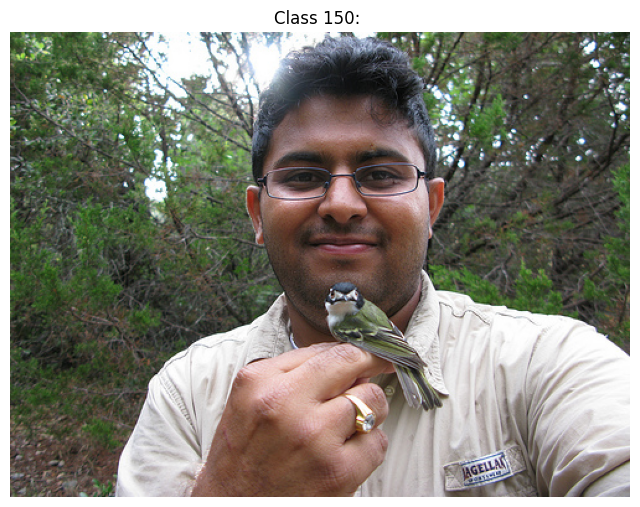

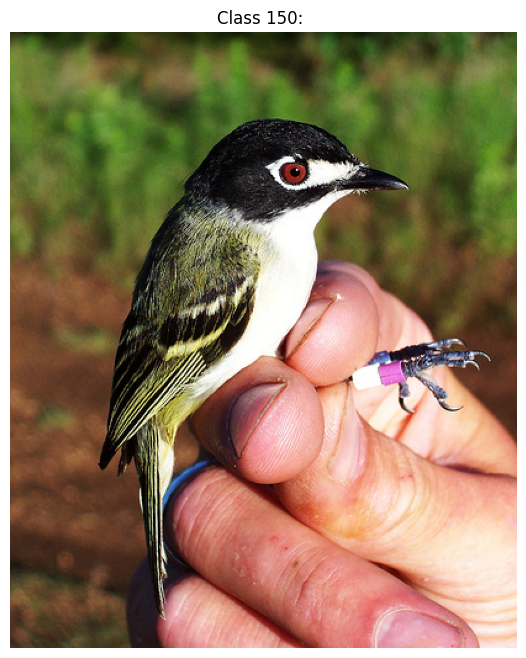

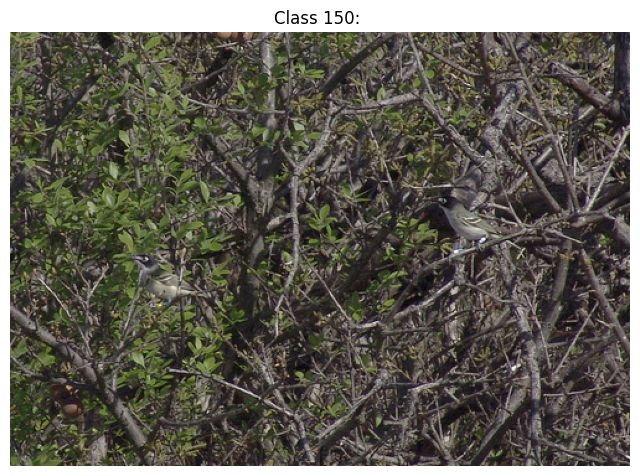

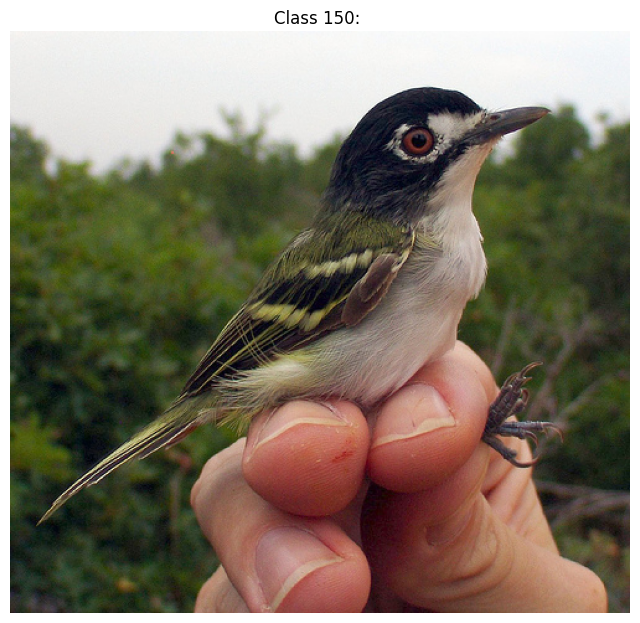

In [10]:
import matplotlib.pyplot as plt

def show_image_from_class(dataset, class_idx, num_images=4):
    class_name = dataset.get_class_name(class_idx)
    print(f"Showing {num_images} image(s) from class {class_idx}: {class_name}")
    
    # Filter the dataset to get images of the specified class
    class_images = dataset.data[dataset.data['label'] == class_idx]
    
    for i in range(min(num_images, len(class_images))):
        # Get a random image from the class
        img_info = class_images.iloc[i]
        img_path = img_info['filepath']
        
        # Load and display the image
        img = Image.open(img_path).convert('RGB')
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(f"Class {class_idx}: {class_name}")
        plt.axis('off')
        plt.show()

# Show an image from class 183
show_image_from_class(test_dataset, class_idx=150)


In [7]:
train_dataset.data

,filename,label,filepath,class_name
0,Black_footed_Albatross_0004_2731401028.jpg,0,dataset/Train\Train\Black_footed_Albatross_000...,Black footed Albatross
1,Black_footed_Albatross_0008_1384283201.jpg,0,dataset/Train\Train\Black_footed_Albatross_000...,Black footed Albatross
2,Black_footed_Albatross_0011_820118444.jpg,0,dataset/Train\Train\Black_footed_Albatross_001...,Black footed Albatross
3,Black_footed_Albatross_0003_2981373810.jpg,0,dataset/Train\Train\Black_footed_Albatross_000...,Black footed Albatross
4,Black_footed_Albatross_0021_2443213385.jpg,0,dataset/Train\Train\Black_footed_Albatross_002...,Black footed Albatross
...,...,...,...,...
4824,Common_Yellowthroat_0012_2573777857.jpg,199,dataset/Train\Train\Common_Yellowthroat_0012_2...,Common Yellowthroat
4825,Common_Yellowthroat_0002_2679007659.jpg,199,dataset/Train\Train\Common_Yellowthroat_0002_2...,Common Yellowthroat
4826,Common_Yellowthroat_0009_2099303008.jpg,199,dataset/Train\Train\Common_Yellowthroat_0009_2...,Common Yellowthroat
4827,Common_Yellowthroat_0008_2691070273.jpg,199,dataset/Train\Train\Common_Yellowthroat_0008_2...,Common Yellowthroat


In [9]:
test_dataset.data["label"].value_counts()


label
142    8
187    8
35     8
130    8
128    8
      ..
170    4
159    4
43     4
181    4
189    4
Name: count, Length: 200, dtype: int64

In [7]:
train_dataset.get_class_name(class_idx=0)

'Black footed Albatross'

In [8]:
# Define the model
class BirdClassifier(nn.Module):
    def __init__(self, num_classes=200):
        super(BirdClassifier, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Create the model
model = BirdClassifier().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)
    
    for epoch in range(num_epochs):
        print("training")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            print(inputs.shape)
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Evaluation function
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Train the model
train_model(model, criterion, optimizer, train_loader, num_epochs=10)



cuda
training


In [ ]:
# Evaluate the model
evaluate_model(model, test_loader)

Try using different models


In [ ]:
from torchvision import models

class BirdClassifier(nn.Module):
    def __init__(self, architecture='resnet50', num_classes=200):
        super(BirdClassifier, self).__init__()
        if architecture == 'resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        elif architecture == 'efficientnet_b0':
            self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        elif architecture == 'mobilenet_v2':
            self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        
        # Replace the last fully connected layer
        if architecture.startswith('resnet'):
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        elif architecture == 'efficientnet_b0':
            num_ftrs = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        elif architecture == 'mobilenet_v2':
            num_ftrs = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Try different models
models_to_try = ['resnet50', 'efficientnet_b0', 'mobilenet_v2']
results = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for arch in models_to_try:
    print(f"Training {arch}...")
    model = BirdClassifier(architecture=arch).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_model(model, criterion, optimizer, train_loader, num_epochs=10)
    top1_acc, avg_acc_per_class, _ = evaluate_model(model, test_loader)
    
    results[arch] = {'top1_acc': top1_acc, 'avg_acc_per_class': avg_acc_per_class}

# Print results
for arch, metrics in results.items():
    print(f"{arch}: Top-1 Accuracy: {metrics['top1_acc']:.2f}%, Avg Accuracy per Class: {metrics['avg_acc_per_class']:.2f}%")

Ensemble method

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
    
    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.stack(outputs).mean(dim=0)

# Create an ensemble of the best performing models
best_models = [BirdClassifier(arch).to(device) for arch in ['resnet50', 'efficientnet_b0']]
ensemble_model = EnsembleModel(best_models).to(device)

# Train the ensemble
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)
train_model(ensemble_model, criterion, optimizer, train_loader, num_epochs=10)

# Evaluate the ensemble
top1_acc, avg_acc_per_class, _ = evaluate_model(ensemble_model, test_loader)
print(f"Ensemble: Top-1 Accuracy: {top1_acc:.2f}%, Avg Accuracy per Class: {avg_acc_per_class:.2f}%")

Transfer learning with gradual unfreezing

In [ ]:
def train_with_gradual_unfreezing(model, criterion, optimizer, train_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze the last layer
    for param in model.model.fc.parameters():
        param.requires_grad = True
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        
        # Gradually unfreeze more layers
        if epoch == 3:
            for param in model.model.layer4.parameters():
                param.requires_grad = True
        elif epoch == 6:
            for param in model.model.layer3.parameters():
                param.requires_grad = True

# Train with gradual unfreezing
model = BirdClassifier('resnet50').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_with_gradual_unfreezing(model, criterion, optimizer, train_loader, num_epochs=10)

# Evaluate the model
top1_acc, avg_acc_per_class, _ = evaluate_model(model, test_loader)
print(f"Gradual Unfreezing: Top-1 Accuracy: {top1_acc:.2f}%, Avg Accuracy per Class: {avg_acc_per_class:.2f}%")

Data augmentation

In [ ]:
from torchvision import transforms
from PIL import ImageFilter

class GaussianBlur(object):
    def __init__(self, radius):
        self.radius = radius
    
    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(radius=self.radius))

# More aggressive data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    GaussianBlur(radius=2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test transform remains the same
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Update your datasets with the new transforms
train_dataset = CUB200Dataset(root_dir, split='Train', transform=train_transform)
test_dataset = CUB200Dataset(root_dir, split='Test', transform=test_transform)

# Update your data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Train the model with data augmentation
model = BirdClassifier('resnet50').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, train_loader, num_epochs=10)

# Evaluate the model
top1_acc, avg_acc_per_class, _ = evaluate_model(model, test_loader)
print(f"Data Augmentation: Top-1 Accuracy: {top1_acc:.2f}%, Avg Accuracy per Class: {avg_acc_per_class:.2f}%")

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [9]:
def extract_features(dataset):
    features = []
    labels = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        # Convert image to numpy array and flatten it
        feature = image.numpy().flatten()
        features.append(feature)
        labels.append(label)
    return np.array(features), np.array(labels)

In [10]:
# Extract features from train and test datasets
X_train, y_train = extract_features(train_dataset)
X_test, y_test = extract_features(test_dataset)

In [11]:
# Train a decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [ ]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)

In [ ]:
# Make predictions
y_pred = dt_classifier.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# If you want to get the average accuracy per class
class_accuracies = classification_report(y_test, y_pred, output_dict=True)
avg_accuracy_per_class = np.mean([class_accuracies[str(i)]['f1-score'] for i in range(200)])
print(f"\nAverage Accuracy per Class: {avg_accuracy_per_class:.2f}")